# Importing Libraries

In [349]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import __version__
%matplotlib inline 

# We will be using plotly to for interactive visulization and Cufflink connects it with pandas
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

# In case, kernel is not able to take the load of the visualization then it will not generate output therfore, 
# it will not crash.
init_notebook_mode(connected=True)
cf.go_offline()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Importing Zillows data to forecast the value of the properties in year 2018

In [350]:
df = pd.read_csv("zillows.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
1,84654,60657,Chicago,IL,Chicago,Cook,2,167700.0,166400.0,166700.0,...,368600,370200,372300,375300.0,378700,381400,381800,382100,383300,385100
2,61637,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
3,84616,60614,Chicago,IL,Chicago,Cook,4,195800.0,193500.0,192600.0,...,398900,401200,403200,405700.0,408300,408800,408000,410100,412200,412200
4,93144,79936,El Paso,TX,El Paso,El Paso,5,59100.0,60500.0,60900.0,...,82400,82300,82400,82300.0,82500,83200,83900,84100,83900,83700


In [351]:
# Data in the City column is uncleaned, That is the reason, I am not using City column to filter data for NYC.
# Instead, I am using State and Metro columns for filtering.
df[(df["State"] == "NY") & (df["Metro"] == "New York")]['City']

0                     New York
2                     New York
13                    New York
14                    New York
20                    New York
31                    New York
51                    New York
67                    New York
70                    New York
108                   New York
189                   New York
211                    Yonkers
378                   New York
437                 Huntington
579                   New York
607           Town of Newburgh
621                   New York
642                 Middletown
667                   New York
763                   New York
783              Town of Islip
893                   New York
1078                 Patchogue
1179                Long Beach
1228      Town of Poughkeepsie
1322                    Ramapo
1408                Huntington
1427      Town of Poughkeepsie
1554                  New York
1743                  New York
                 ...          
7244            Greenwood Lake
7277    

In [352]:
#Making strategy to preprocess.
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
1,84654,60657,Chicago,IL,Chicago,Cook,2,167700.0,166400.0,166700.0,...,368600,370200,372300,375300.0,378700,381400,381800,382100,383300,385100
2,61637,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
3,84616,60614,Chicago,IL,Chicago,Cook,4,195800.0,193500.0,192600.0,...,398900,401200,403200,405700.0,408300,408800,408000,410100,412200,412200
4,93144,79936,El Paso,TX,El Paso,El Paso,5,59100.0,60500.0,60900.0,...,82400,82300,82400,82300.0,82500,83200,83900,84100,83900,83700


# Function for Zillows Data Preprocessing
We are creating an User defined function to improve the code reusability,
Since, this preprocessing will be used by all the models.

In [353]:
# Filtering Data For NYC and Selecting Columns
# Removing unneccessary columns
# Pivoting Years for better analysis
# splitting year and month... as we only need year for forecasting...
# Drop unnecessary columns created during splitting and melting...
# Renaming RegionName column to Zipcode for better readability

def dataPreprocess(df):
    # Filter data for New York City
    df = df[(df["State"] == "NY") & (df["Metro"] == "New York")].copy()

    # Dropping unnecessary columns..
    df.drop(["RegionID","City","State","Metro","CountyName","SizeRank"],axis=1,inplace=True)

    # Melting year columns to rows...
    df = pd.melt(df, id_vars=['RegionName'], value_vars=list(df.columns[6:])).copy()

    # splitting year and month... as we only need year for forecasting...
    df[["year","month"]] = df["variable"].str.split(pat="-", n=-1, expand=True).copy()
    
    # change datatype of year to int again...
    df["year"] = df["year"].astype(int).copy()

    # Drop unnecessary columns created during splitting and melting...
    df.drop(["variable","month"],axis=1,inplace=True)

    df.rename(index=str, columns={"RegionName": "zipcode"},inplace=True)
    df['zipcode']=df['zipcode'].astype(str).copy()
    return df


In [354]:
df_1=dataPreprocess(df)
df_1.dtypes

zipcode     object
value      float64
year         int64
dtype: object

In [355]:
df_1.iplot(kind='bar',x='year',y='value',bins=50)


We could see that price of apartments are increasing over the time in entire NYC.However, from 1996-2003. We have lots of NULL values. Therefore we need to handle them or will not use data of that time for our model.

# Assumptions for making Machine Learning Models.

1. We are not using data before 2012 in our model for 2 reasons: First, We have lots of null values for these time frame. Second, because of 2008-2011 recession, the prices of real estate properties has declined. If we use this data, It would potentially mislead our model against predicting correctly.

2. We are considering current year as 2017 and forecasting for 2018. As, in the given problem years are not mentioned. So, assuming it.

3. By making various models, will try to predict the value of the properties in year 2018 in order to calculate the profit percentage.

# Making Decision tree

In [356]:
# instantiating to get the preprocess data
df_tree = dataPreprocess(df).copy()

In [357]:
# Selecting data from 2012 to 2017

# In case we there is any missing value between the given time frame, decision tree can handle missing valu
# So, we are not imputing.
df_tree = df_tree[(df_tree["year"]>=2012) & (df_tree["year"]<=2017)].copy()
df_tree['year'].unique()

array([2012, 2013, 2014, 2015, 2016, 2017])

In [358]:
# Imputing missing values with the mean values for corresponding RegionName Category...
#df_tree['value'] = df_tree.groupby(["zipcode","year"]).value.transform(lambda x: x.fillna(x.mean()))

# Selecting Matrix of feature and dependent variable...
df_tree = df_tree.loc[:,["zipcode","year","value"]].copy()

#taking x and y variable to build the model

#Contains Zipcode and Year
# Zipcode here is a categorical variable. Howeverm we don;t need to enocode it since Decison tree can handle it.
X = df_tree.iloc[:, :-1].values

#Contains Value. Target Variable
y = df_tree.iloc[:, 2].values

df_tree.head()

,zipcode,year,value
28704,10025,2012,904400.0
28705,10023,2012,1395200.0
28706,10128,2012,1057500.0
28707,10011,2012,1509600.0
28708,10003,2012,1348500.0


In [359]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [360]:
from sklearn import tree
tree_model=tree.DecisionTreeRegressor()
tree_model.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

# EVALAUATING PERFORMANCE ON TEST DATA

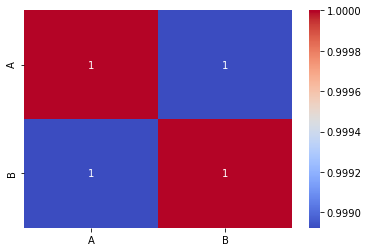

In [361]:
predicitions=tree_model.predict(X_test)
df_2=pd.DataFrame()
df_2['A']=y_test
df_2['B']=predicitions
tc=df_2.corr()
sns.heatmap(tc,annot=True,cmap='coolwarm')
#plt.scatter(y_test,predicitions,cmap='coolwarm')
#sns.lmplot(x='predicitions',y='y_test',data=df_2)
#sns.jointplot(x='predicitions',y='y_test',data=df_2,kind='hex')

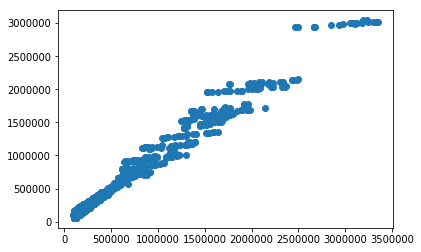

In [362]:
plt.scatter(y_test,predictions)

The Scatter plot reveals that our model is performing well on test data since plots are not scattered.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



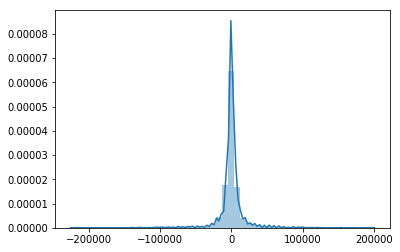

In [363]:
sns.distplot(y_test-predicitions)


# The error term is almost normaly distributed which again foster our model.

# ACTUAL FORECASTIING FOR DECISION TREE

In [364]:
df_tree.head()

,zipcode,year,value
28704,10025,2012,904400.0
28705,10023,2012,1395200.0
28706,10128,2012,1057500.0
28707,10011,2012,1509600.0
28708,10003,2012,1348500.0


In [365]:

# Actual data for prediction...
df_tree = df_tree[df_tree["year"] == 2017].loc[:,["zipcode","year","value"]].copy()
df_tree["year"] = 2018
X_pred = df_tree.iloc[:, :-1].values

# Predicting the results
df_tree['predicted_value_2018'] = tree_model.predict(X_pred)

df_tree= df_tree.groupby("zipcode").mean()
df_tree.head()


,year,value,predicted_value_2018
zipcode,,,
10003,2018,2.016550e+06,2054475.0
10011,2018,2.373500e+06,2383250.0
10013,2018,3.224517e+06,3230550.0
10014,2018,2.473150e+06,2468100.0
10021,2018,1.717183e+06,1722920.0


In [366]:
df_tree['hike_in_one_year'] = df_tree['predicted_value_2018'] - df_tree['value']
df_tree.head()

,year,value,predicted_value_2018,hike_in_one_year
zipcode,,,,
10003,2018,2.016550e+06,2054475.0,37925.000000
10011,2018,2.373500e+06,2383250.0,9750.000000
10013,2018,3.224517e+06,3230550.0,6033.333333
10014,2018,2.473150e+06,2468100.0,-5050.000000
10021,2018,1.717183e+06,1722920.0,5736.666667


# MODEL TUNING USING k-Fold Cross Validation

In [367]:
# Applying k-FoldValidation
from sklearn.model_selection import cross_val_score
accuracy_tree=cross_val_score(estimator=tree_model,X=X_train,y=y_train,cv=10)

In [368]:
# 10 Accuracy that we are getting after dividing test data into 10 sets
accuracy_tree

array([ 0.99814825,  0.9975716 ,  0.99814448,  0.99813278,  0.99261255,
        0.99768769,  0.99746718,  0.99844894,  0.99736798,  0.99724986])

In [369]:
accuracy_tree.mean()

0.99728313112121847

In [370]:
# We could see that bias variance trade off is very less. And our model is trained really well
accuracy_tree.std()

0.001602335961363693

# Linear Regression Model


In [371]:
#Building Linear Regression to predict the value of 2018 
# taking Data of last 5 yrs.. As there ar many missing values in 1996-2004 data
# Even, we dont want to take into effect of 2009 Real Estate Recession
#So taking data from 2012-2017

df_linear=dataPreprocess(df)

# Select require data for forecasting...
df_linear= df_linear[(df_linear["year"]>=2012) & (df_linear["year"]<=2017)].copy()
df_linear.head()

,zipcode,value,year
28704,10025,904400.0,2012
28705,10023,1395200.0,2012
28706,10128,1057500.0,2012
28707,10011,1509600.0,2012
28708,10003,1348500.0,2012


In [372]:
df_linear.iplot(kind='bar',x='year',y='value',colors='Blue')

In [278]:
# Imputing missing values with the mean values for corresponding RegionName Category...
df_linear['value'] = df_linear.groupby(["zipcode","year"]).value.transform(lambda x: x.fillna(x.mean()))

# Selecting Metrix of feature and dependent variable...
df_linear = df_linear.loc[:,["zipcode","year","value"]].copy()
X = df_linear.iloc[:, :-1].values
y = df_linear.iloc[:, 2].values

# Encoding categorical data
# Encoding the Independent Variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
enc = LabelEncoder()
X[:,0] = enc.fit_transform(X[:,0])
onehotencoder = OneHotEncoder(categorical_features = [0])
X = onehotencoder.fit_transform(X).toarray().copy()

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Accuracy of Trained Model

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



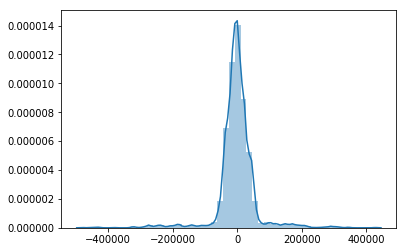

In [279]:
# Predicting the Test set results
predictions=lm.predict(X_test)
sns.distplot(y_test-predictions)

# Since Error term is normally distributed so it states that is it is good model.

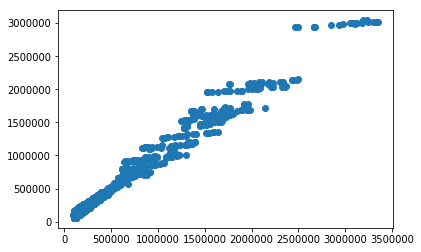

In [280]:
plt.scatter(y_test,predictions)


In [281]:
# Since, points are not too much scattered so we can assume that model performed reasonably well on training set

# ACTUAL FORECASTING

In [282]:
# Actual data for prediction...
df_linear= df_linear[df_linear["year"] == 2017].loc[:,["zipcode","year","value"]].copy()
df_linear["year"] = 2018
X_pred = df_linear.iloc[:, :-1].values




# Encoding categorical data
# Encoding the Independent Variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
enc = LabelEncoder()
X_pred[:,0] = enc.fit_transform(X_pred[:,0])
onehotencoder = OneHotEncoder(categorical_features = [0])
X_pred = onehotencoder.fit_transform(X_pred).toarray()

# Predicting the results
df_linear["predicted_value_2018"] = lm.predict(X_pred)

#Hike is the name of varaible given to the increase inv alue from 2017 to 2018
df_linear["hike_in_one_year"] = df_linear["predicted_value_2018"] - df_linear["value"]
df_linear = df_linear.groupby("zipcode").mean()
df_linear.head()

,year,value,predicted_value_2018,hike_in_one_year
zipcode,,,,
10003,2018,2.016550e+06,1.795434e+06,-221115.653201
10011,2018,2.373500e+06,2.074999e+06,-298500.659907
10013,2018,3.224517e+06,3.062443e+06,-162073.761834
10014,2018,2.473150e+06,2.173671e+06,-299478.812302
10021,2018,1.717183e+06,1.538696e+06,-178487.593909


In [283]:
# ZIP CODE WISE change in the price of the properties in one year i.e from 2017 to 2018

df_linear = df_linear.groupby('zipcode').mean().copy()
df_linear = df_linear.reset_index().copy()

df_linear.head()

,zipcode,year,value,predicted_value_2018,hike_in_one_year
0,10003,2018,2.016550e+06,1.795434e+06,-221115.653201
1,10011,2018,2.373500e+06,2.074999e+06,-298500.659907
2,10013,2018,3.224517e+06,3.062443e+06,-162073.761834
3,10014,2018,2.473150e+06,2.173671e+06,-299478.812302
4,10021,2018,1.717183e+06,1.538696e+06,-178487.593909


In [284]:

#df_linear.iplot(kind='bar',x='zipcode',y='hike_in_one_year',size=100,colors='green')


# Performance Tuning

In [285]:
# Applying k-FoldValidation
from sklearn.model_selection import cross_val_score
acc_linear=cross_val_score(estimator=lm,X=X_train,y=y_train,cv=10)

In [286]:
acc_linear.mean()


0.97997746188082679

In [287]:
acc_linear.std()

0.0030725980161192571

# Loading Airbnb Data

In [288]:
# Importing airbnb data
df_airbnb = pd.read_csv("listings.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (43,88) have mixed types. Specify dtype option on import or set low_memory=False.



In [289]:
df_airbnb[['weekly_price','monthly_price','price']]

,weekly_price,monthly_price,price
0,NaN,NaN,$99.00
1,NaN,NaN,$200.00
2,NaN,NaN,$300.00
3,$775.00,NaN,$125.00
4,$350.00,"$1,200.00",$69.00
5,$550.00,NaN,$125.00
6,NaN,NaN,$85.00
7,NaN,NaN,$39.00
8,NaN,NaN,$95.00
9,NaN,NaN,$125.00


Since, weekly and monthly price have lot of missing values. So will take price coulmn to calculate revenue earned

# Selecting required columns and cleaning data of airbnb

1. I am filtering on state, market and country to select the data of only NYC.

2. I am also filtering on room type column to select Entire house only. 
As, room type column also have shared rooms which we are not interested in analysing.

3. I am filtering on bedrooms, because we are only interested in analysing the 2 BHK properties.

In [290]:
# Feature selection and data cleaning
df_airbnb = df_airbnb[["state","zipcode","market","country","latitude","longitude","price","bedrooms","room_type"]].copy()
df_airbnb = df_airbnb[(df_airbnb["state"] == "NY") & (df_airbnb["market"] == "New York") & \
                      (df_airbnb["country"] == "United States") & (df_airbnb['room_type'] == 'Entire home/apt')\
                      & (df_airbnb['bedrooms'] == 2)][["zipcode","price"]].copy()

#Cleaning the price columns
df_airbnb["price"] = df_airbnb.price.str.replace('$','').copy()
df_airbnb["price"] = df_airbnb.price.str.replace(',','').copy()

# change datatype of year to int again...
df_airbnb["price"] = df_airbnb["price"].astype(float).copy()

# Since, its given that occupancy is 75%. We are caluclating rent earned in a year.
#Created calculated field for rent earned per year.

df_airbnb["rent earned per year"] = 273 * df_airbnb["price"]

# Average price per zipcode
df_airbnb = df_airbnb.groupby("zipcode").mean().copy()

df_airbnb.head()

,price,rent earned per year
zipcode,,
10001.0,247.800000,67649.400000
10002.0,249.000000,67977.000000
10003.0,327.523810,89414.000000
10010.0,301.407407,82284.222222
10011.0,372.466667,101683.400000


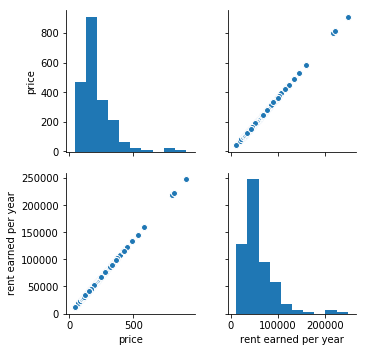

In [291]:
sns.pairplot(df_airbnb)

# Will merge the data from the chosen model with airbnb to do the final analysis.

In [292]:
#pd.merge(df,df_airbnb,how='inner',on='zipcode')
result = pd.concat([df_tree, df_airbnb], axis=1, join='inner')
result

,year,value,predicted_value_2018,hike_in_one_year,price,rent earned per year
zipcode,,,,,,
10003,2018,2.016550e+06,2.054475e+06,37925.000000,326.466019,89125.223301
10011,2018,2.373500e+06,2.383250e+06,9750.000000,369.082353,100759.482353
10013,2018,3.224517e+06,3.230550e+06,6033.333333,393.693548,107478.338710
10014,2018,2.473150e+06,2.468100e+06,-5050.000000,332.505747,90774.068966
10021,2018,1.717183e+06,1.722920e+06,5736.666667,296.058824,80824.058824
10022,2018,1.884400e+06,1.884400e+06,0.000000,375.228571,102437.400000
10023,2018,2.013717e+06,1.988000e+06,-25716.666667,296.620690,80977.448276
10025,2018,1.358600e+06,1.391550e+06,32950.000000,293.140187,80027.271028
10028,2018,1.909750e+06,1.931480e+06,21730.000000,275.322581,75163.064516


# Calculating Profit

Since, It would be biased to calculate profit percentage without considering initial cost of a property.
Hence, I am calculating the percentage profit earned relative to the initial investment value on a property. 

The formula which we are using to calculate profit percentage is as below:

    Profit percentage = ( "Rent earned per year"+"hike in one year" ) / "initial cost of a property"

In [293]:
result["profit percentage"] = ( result["rent earned per year"] + result["hike_in_one_year"] ) / ( result["value"])
result.reset_index()

,zipcode,year,value,predicted_value_2018,hike_in_one_year,price,rent earned per year,profit percentage
0,10003,2018,2.016550e+06,2.054475e+06,37925.000000,326.466019,89125.223301,0.063004
1,10011,2018,2.373500e+06,2.383250e+06,9750.000000,369.082353,100759.482353,0.046560
2,10013,2018,3.224517e+06,3.230550e+06,6033.333333,393.693548,107478.338710,0.035203
3,10014,2018,2.473150e+06,2.468100e+06,-5050.000000,332.505747,90774.068966,0.034662
4,10021,2018,1.717183e+06,1.722920e+06,5736.666667,296.058824,80824.058824,0.050409
5,10022,2018,1.884400e+06,1.884400e+06,0.000000,375.228571,102437.400000,0.054361
6,10023,2018,2.013717e+06,1.988000e+06,-25716.666667,296.620690,80977.448276,0.027442
7,10025,2018,1.358600e+06,1.391550e+06,32950.000000,293.140187,80027.271028,0.083157
8,10028,2018,1.909750e+06,1.931480e+06,21730.000000,275.322581,75163.064516,0.050736
9,10036,2018,1.729167e+06,1.731375e+06,2208.333333,445.666667,121667.000000,0.071639


In [294]:
result = result.reset_index().copy()

Text(0,0.5,'Profit Ratio')

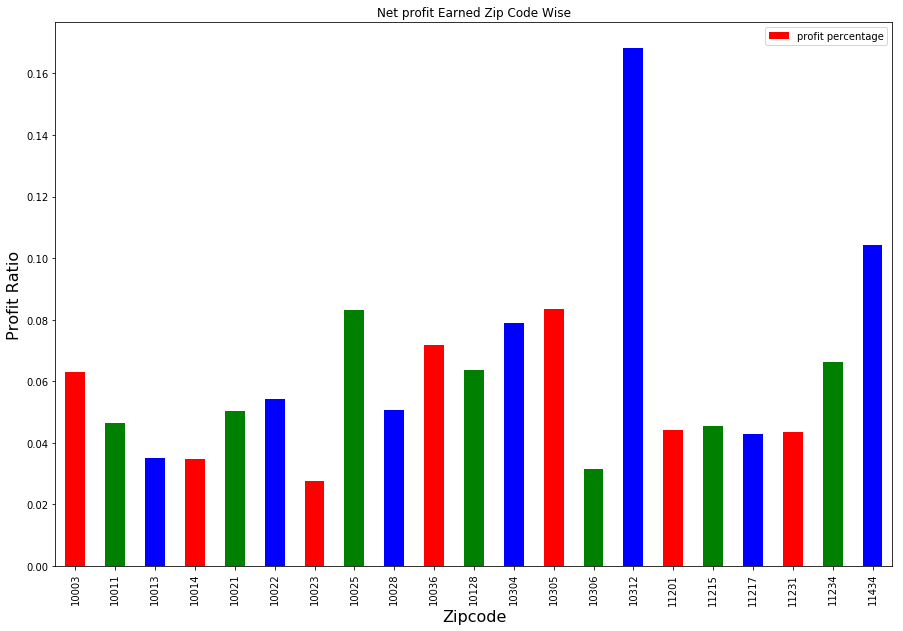

In [387]:
df_8=result.plot(kind='bar',x='zipcode',y='profit percentage',figsize=(15, 10),\
            title= 'Net profit Earned Zip Code Wise',color='rgb',legend=True)
df_8.set_xlabel('Zipcode',fontsize=16)
df_8.set_ylabel('Profit Ratio',fontsize=16)

# Thus, we could clearly see that zipcode 10312 followed by 11434 are the best to invest in as its cumulative return is the most.
# Rent means rent for one year and increase in value of property will increase maximum

Text(0,0.5,'Price($)')

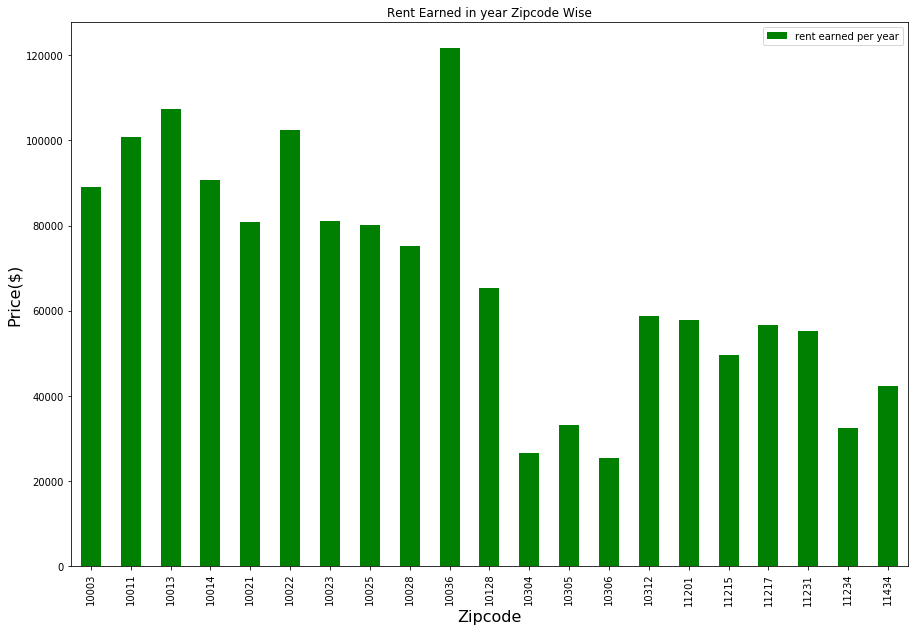

In [384]:
df_7=result.plot(kind='bar',x='zipcode',y='rent earned per year',\
            title='Rent Earned in year Zipcode Wise',figsize=(15, 10),color='g')
df_7.set_xlabel('Zipcode',fontsize=16)
df_7.set_ylabel('Price($)',fontsize=16)

In [ ]:
# If we are intersted in just knowing that properties of which Zipocde generates the most rent.

Text(0,0.5,'Price($)')

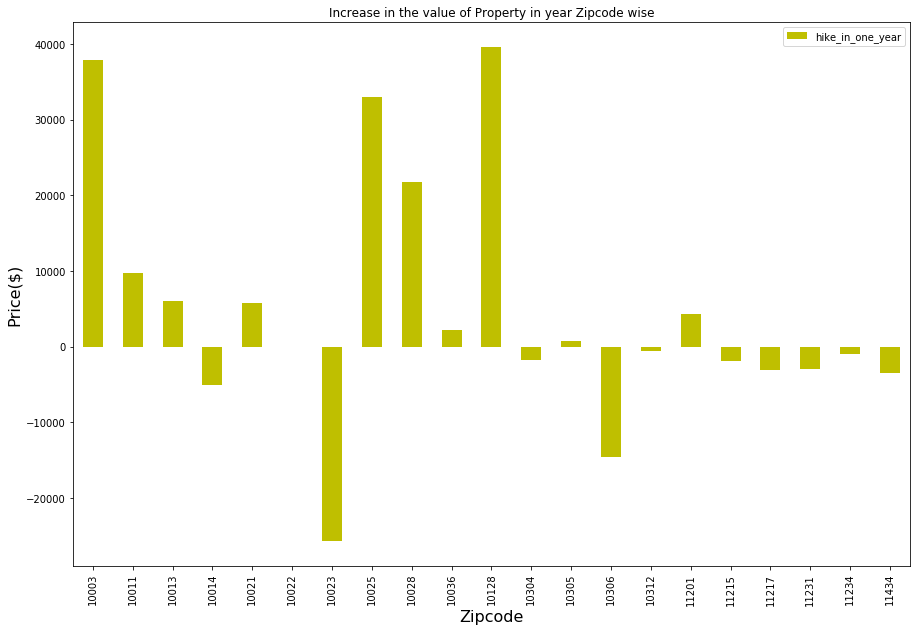

In [385]:
# Hike i.e increase in value componenet analysis
df_6=result.plot(kind='bar',x='zipcode',y='hike_in_one_year',color='y',\
            figsize=(15, 10),title='Increase in the value of Property in year Zipcode wise')
df_6.set_xlabel('Zipcode',fontsize=16)
df_6.set_ylabel('Price($)',fontsize=16)

# We could analysze change in the value of proerty over a year. that is from 2017 to 2018.

Text(0,0.5,'Price($)')

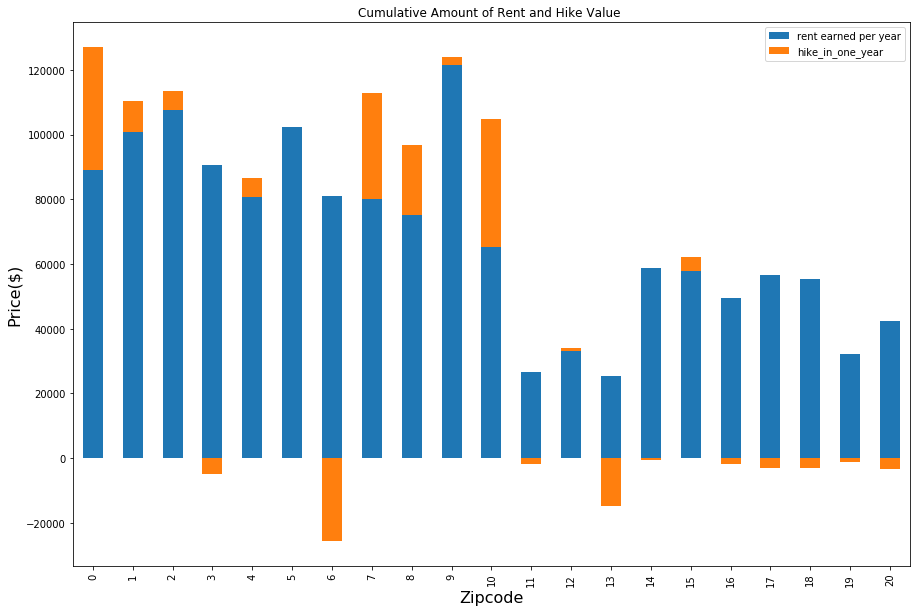

In [386]:
df_5=result[['zipcode','rent earned per year','hike_in_one_year']].plot(kind='bar',stacked=True,\
             figsize=(15, 10),title='Cumulative Amount of Rent and Hike Value ')
df_5.set_xlabel('Zipcode',fontsize=16)
df_5.set_ylabel('Price($)',fontsize=16)

# Cumulative analysis of the rent and the change in the apartment value over a year.

In [251]:
df_4 = result.sort_values('profit percentage',ascending=False)
df_4[["zipcode","profit percentage"]]

,zipcode,profit percentage
14,10312,0.168205
20,11434,0.104422
12,10305,0.083458
7,10025,0.083157
11,10304,0.078947
9,10036,0.071639
19,11234,0.066350
10,10128,0.063550
0,10003,0.063004
5,10022,0.054361


Final list of the zipcode in sorted(desc). 10312 seems the most profitable Zipcode to invest in.

# THE END